# Application

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time
from sklearn.model_selection import train_test_split
import time

In [19]:
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from datetime import datetime

Set parameters:

In [3]:
path = 'C:/Users/Meier/Institut für Statistik Dropbox/Johanna Meier/Structural Breaks + DL/Application/' 

In [4]:
data_name = 'gridfreqs_2022-10-01_Loc1'
#data_name = 'gridfreqs_2022-10-01_Loc2'
#data_name = 'gridfreqs_2022-10-08_Loc1'
#data_name = 'gridfreqs_2022-10-08_Loc2'

In [5]:
model_name = 'RNN' # 'RNN', 'LSTM', 'GRU'

In [6]:
test_size = 0.1           # proportion of test set
lags = 1                  # number of lags as features

In [7]:
batch_size = 128
n_epochs = 500

In [8]:
# set parameters
input_dim = lags                  # number of lagged features in X
hidden_dim = 10                   # number of hidden nodes per layer
layer_dim = 1                     # number of layers
output_dim = 1                    # output dimension (1 for univariate output)
dropout = 0                       # dropout proportion (only before the last sequential layer)
learning_rate = 1e-3              # learning rate for Adam optimizer
weight_decay = 1e-6               # weight decay for Adam optimizer

# save model parameters in dict
model_params = {'input_dim': input_dim, 'hidden_dim' : hidden_dim,'layer_dim' : layer_dim, 'output_dim' : output_dim, 'dropout_prob' : dropout}        

Models:

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        self.rnn.flatten_parameters() # ------------------------------------------------------------------
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        self.lstm.flatten_parameters() # ------------------------------------------------------------------
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        self.gru.flatten_parameters() # ------------------------------------------------------------------
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [10]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [32]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, batch_size=64, n_epochs=50, n_features=1):
        
        # train on GPU
        device = torch.device('cuda')
        
        #best_loss = np.infty
        best_train_loss = np.infty
        stop_criterion = 1e-5
        cnt = 0
        patience = 100

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([len(y_batch), -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                b_loss = self.train_step(x_batch, y_batch)
                batch_losses.append(b_loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
                    
            # early stopping
            if ((best_train_loss - training_loss) > stop_criterion):
                best_train_loss = training_loss
                cnt = 0
            else:
                cnt += 1
            if cnt == patience:
                break

        return self.model

    def evaluate(self, best_model, test_loader, batch_size=1, n_features=1):
        # evaluate on GPU
        device = torch.device('cuda')
        model = deepcopy(best_model)
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.view([batch_size, -1]).to(device)
                model.eval()
                yhat = model(x_test)
                predictions.append(yhat.to(device).detach().cpu().numpy())
                values.append(y_test.to(device).detach().cpu().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        #plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [33]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

def format_predictions(predictions, values, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds})
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return {'rmse' : mean_squared_error(df.value, df.prediction)**0.5,
            'mae' : mean_absolute_error(df.value, df.prediction),
            'mape': mean_absolute_percentage_error(df.value, df.prediction),
            'r2' : r2_score(df.value, df.prediction)}

def time_format(seconds: int):
    if seconds is not None:
        seconds = int(seconds)
        d = seconds // (3600 * 24)
        h = seconds // 3600 % 24
        m = seconds % 3600 // 60
        s = seconds % 3600 % 60
        if d > 0:
            return '{:02d}D {:02d}H {:02d}m {:02d}s'.format(d, h, m, s)
        elif h > 0:
            return '{:02d}H {:02d}m {:02d}s'.format(h, m, s)
        elif m > 0:
            return '{:02d}m {:02d}s'.format(m, s)
        elif s > 0:
            return '{:02d}s'.format(s)
    return '-'

Training loop:

In [43]:
def train_loop(data_name, model_name, model_params,path,learning_rate,weight_decay,lags=1,batch_size = 64,n_epochs = 500):
    
    # train on GPU
    device = torch.device('cuda')

    # load data
    with np.load(path+'Data/Frequency of grid/'+data_name+'.npz') as data:
        # extract data and the given number of lagged features
        X_train = np.concatenate((data['X_train'][:,:lags],data['X_val'][:,:lags]),axis=0)
        X_test = data['X_test'][:,:lags]
        y_train = np.concatenate((data['y_train'][:,:lags],data['y_val'][:,:lags]),axis=0)
        y_test = data['y_test']
        
    # scale the data to 0-1
    scaler = MinMaxScaler()
    
    X_train_arr = scaler.fit_transform(X_train)
    X_test_arr = scaler.transform(X_test)

    y_train_arr = scaler.fit_transform(y_train)
    y_test_arr = scaler.transform(y_test)
    
    # convert data to tensors
    train_features = torch.Tensor(X_train_arr)
    train_targets = torch.Tensor(y_train_arr)
    test_features = torch.Tensor(X_test_arr)
    test_targets = torch.Tensor(y_test_arr)

    # build tensor dataset
    train = TensorDataset(train_features, train_targets)
    test = TensorDataset(test_features, test_targets)

    # get batched data
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=False) 
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=False)
            
    # initialise model on GPU
    model = get_model(model_name, model_params).to(device)

    # create loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
            
    # train the model
    model_out = opt.train(train_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=model_params['input_dim'])
    opt.plot_losses()

    # evaluate on test set
    predictions, values = opt.evaluate(model_out, test_loader_one, batch_size=1, n_features=model_params['input_dim'])
    df_result = format_predictions(predictions, values, scaler)
    result_metrics = calculate_metrics(df_result)
    print(result_metrics)
    plt.plot(df_result.value)
    plt.plot(df_result.prediction)
    plt.show()

    # append metrics on test set
    df_metrics = pd.DataFrame(np.expand_dims((result_metrics['rmse'],result_metrics['mae'],result_metrics['mape'],result_metrics['r2']),axis=0),columns=['mse','mae','mape','r2'])

    return df_metrics, df_result

Training:

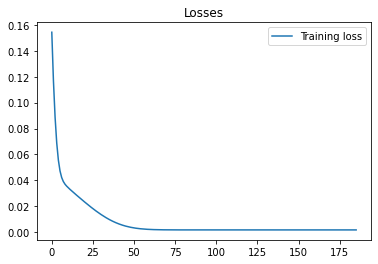

{'rmse': 0.24652459259318688, 'mae': 0.17576583, 'mape': 0.0007311395, 'r2': 0.7163559201772989}


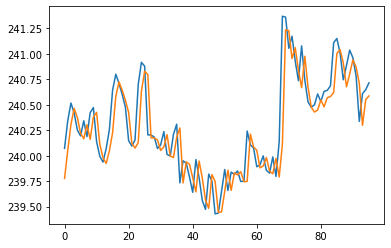

In [44]:
df_metrics, df_result = train_loop(data_name, model_name, model_params,path,learning_rate,weight_decay,lags=lags,batch_size = batch_size,n_epochs = n_epochs)

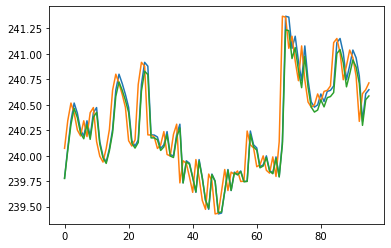

In [45]:
    with np.load(path+'Data/Frequency of grid/'+data_name+'.npz') as data:
        X_train = data['X_train'][:,:lags]
        X_val = data['X_val'][:,:lags]
        X_test = data['X_test'][:,:lags]
        y_train = data['y_train']
        y_val = data['y_val']
        y_test = data['y_test']
        plt.plot(X_test)
        plt.plot(y_test)
        plt.plot(df_result.prediction)
        plt.show()